**Read Me**


* make sure that you have two directories
1. ./data/
2. ./results/


# Import Packages

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
BASE_DIR = 'base_dir'
DATA_DIR = os.path.join(BASE_DIR, 'data')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Models: NetFF and NetCNN

In [4]:
class NetFF(nn.Module):
    def __init__(self):
        super(NetFF, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 300)
        self.fc3 = nn.Linear(300, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1,784)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Functions: train() and test()

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "mnist_cnn.pth"))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Parameters and Data load

In [6]:
seed = 1
epochs = 2
batch_size = 32
test_batch_size = 1000
lr = 0.001 # learning rate
momentum = 0.9
log_interval = 200
save_model = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

transform=transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,)) ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False, transform=transform),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# NetFF model

In [7]:
torch.manual_seed(seed)

model = NetFF().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

if (save_model):
    torch.save(model, os.path.join(RESULTS_DIR, "mnist_NetFF.pth"))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309637
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.329176
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.706647
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.438433
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.593319
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.353528
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.276715
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.546666
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174126
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.285674

Test: Average loss: 0.3004, Accuracy: 9155/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.343893
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.128626
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.349224
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.306493
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.306759
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.119653
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.246272
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.407206
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.331753
Train

# NetCNN Model

In [8]:
torch.manual_seed(seed)

model = NetCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)

if (save_model):
    torch.save(model, os.path.join(RESULTS_DIR, "mnist_NetCNN.pth"))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303299
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.594412
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.223874
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.395195
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.150409
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.188998
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.200789
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.050763
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164883
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.074537

Test: Average loss: 0.1091, Accuracy: 9686/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.322156
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.090695
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.049792
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.107879
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.082395
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.107844
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.161868
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.077340
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.008309
Train

# After Training
* load the trained model
* test with one image or with one directory

In [9]:
load_model = torch.load(os.path.join(RESULTS_DIR, "mnist_NetCNN.pth"), weights_only=False)

base_dir/data/mnist_test_images/test2.jpg 4


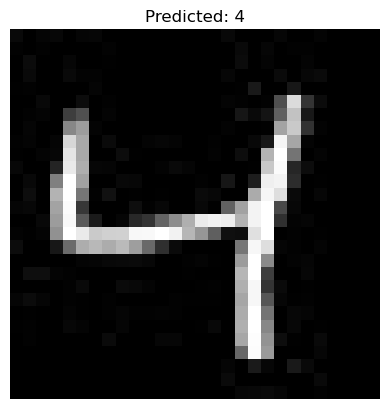

In [10]:
from skimage import io
import time

img_name = os.path.join(DATA_DIR, 'mnist_test_images/test2.jpg')
test_img = io.imread(img_name).reshape(28,28)
test_data = transform(test_img).view(1,1,28,28).to(device)
with torch.no_grad():
  output=load_model(test_data)
print(img_name, output.argmax(dim=1).cpu().numpy()[0]) # Fill in the blank

# Visualize
plt.imshow(test_img, cmap='gray')
plt.title(f"Predicted: {output.argmax(dim=1).cpu().numpy()[0]}") # Fill in the blank
plt.axis('off')
plt.show()

base_dir/data/mnist_test_images/test15.jpg 7


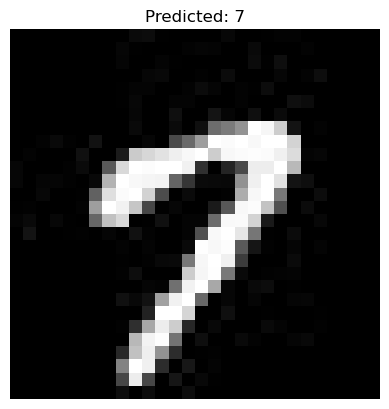

base_dir/data/mnist_test_images/test14.jpg 1


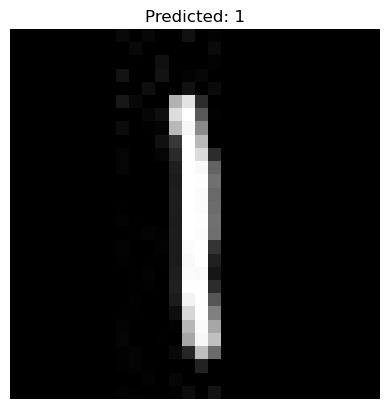

base_dir/data/mnist_test_images/test16.jpg 2


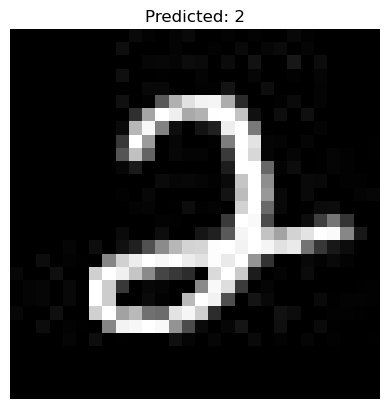

base_dir/data/mnist_test_images/test17.jpg 8


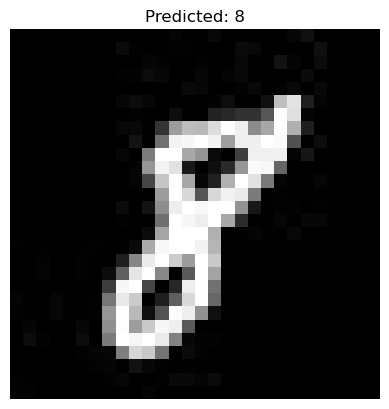

base_dir/data/mnist_test_images/test13.jpg 6


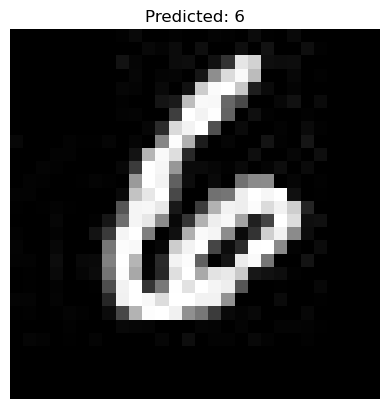

base_dir/data/mnist_test_images/test12.jpg 3


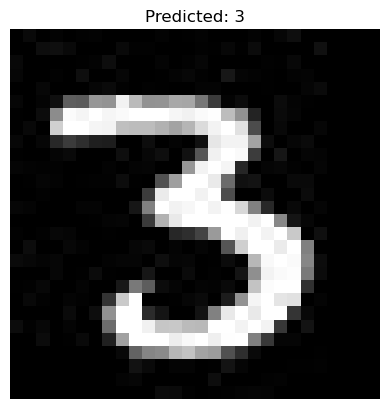

base_dir/data/mnist_test_images/test10.jpg 3


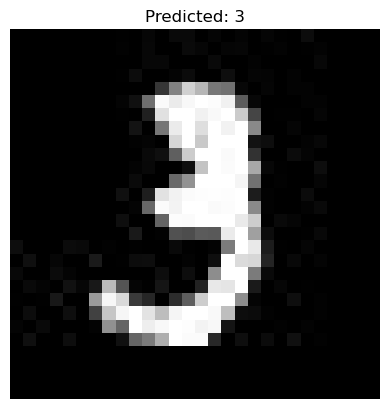

base_dir/data/mnist_test_images/test11.jpg 5


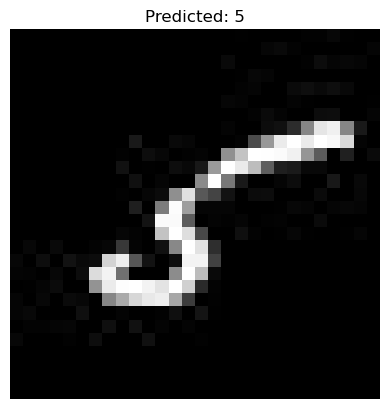

base_dir/data/mnist_test_images/test6.jpg 1


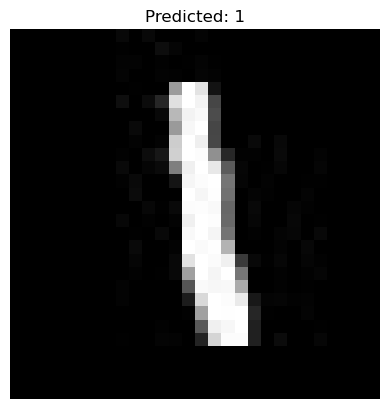

base_dir/data/mnist_test_images/test7.jpg 3


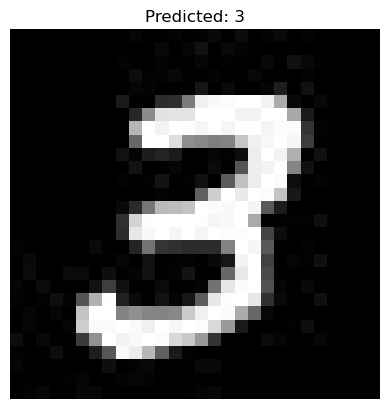

base_dir/data/mnist_test_images/test5.jpg 2


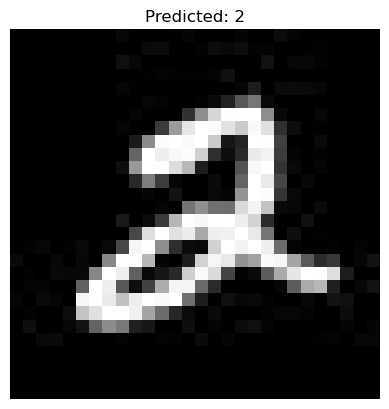

base_dir/data/mnist_test_images/test4.jpg 9


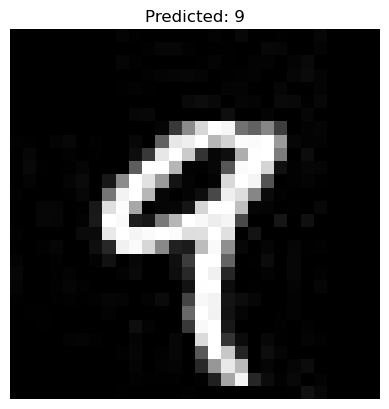

base_dir/data/mnist_test_images/test0.jpg 5


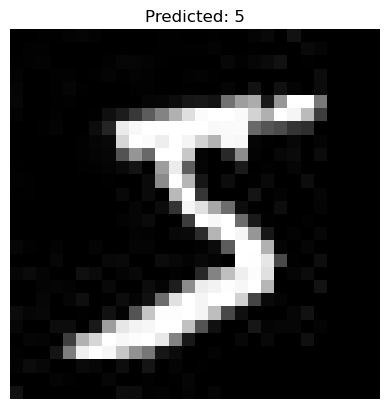

base_dir/data/mnist_test_images/test1.jpg 0


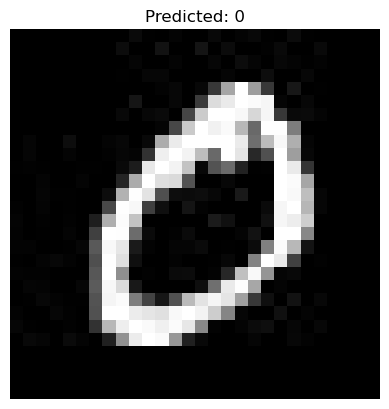

base_dir/data/mnist_test_images/test3.jpg 1


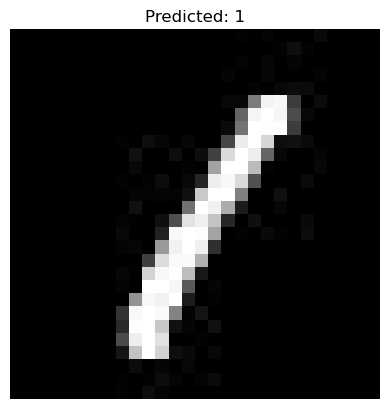

base_dir/data/mnist_test_images/test2.jpg 4


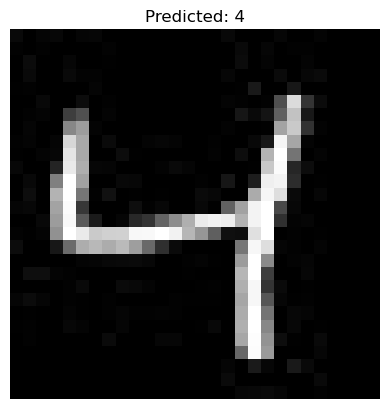

base_dir/data/mnist_test_images/test9.jpg 4


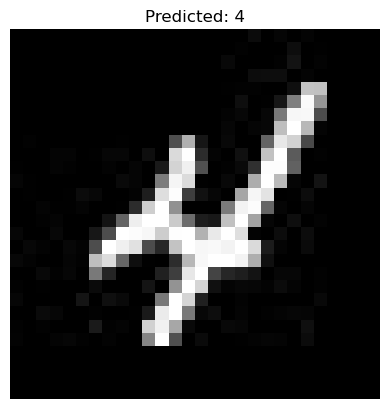

base_dir/data/mnist_test_images/test8.jpg 1


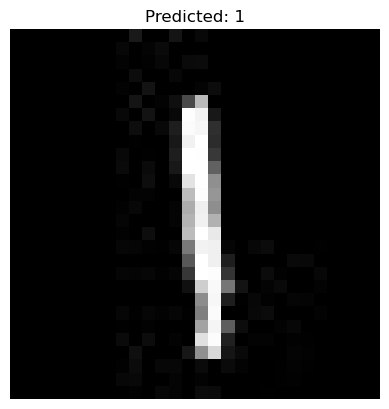

base_dir/data/mnist_test_images/test20.jpg 4


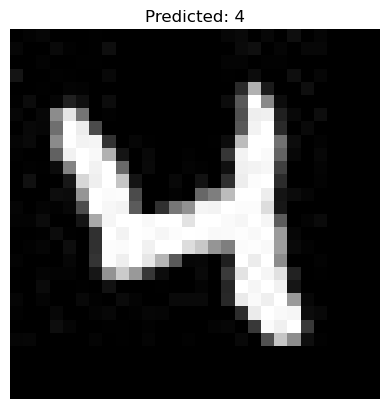

base_dir/data/mnist_test_images/test19.jpg 9


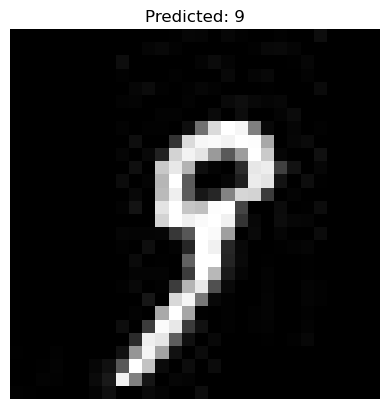

base_dir/data/mnist_test_images/test18.jpg 6


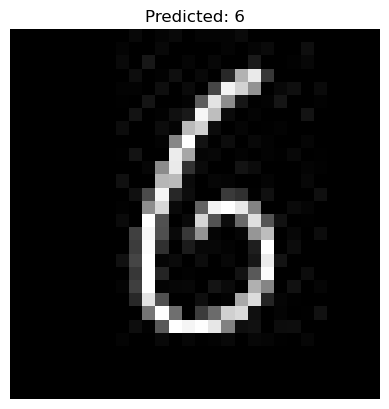

In [11]:
from skimage import io
import time
import glob

file_list = glob.glob(os.path.join(DATA_DIR, "mnist_test_images/*.jpg"))
for img_name in file_list:
  test_img = io.imread(img_name).reshape(28,28)
  test_data = transform(test_img).view(1,1,28,28).to(device)
  with torch.no_grad():
    output=load_model(test_data)
  print(img_name, output.argmax(dim=1).cpu().numpy()[0]) # Fill in the blank

  # Visualize
  plt.imshow(test_img, cmap='gray')
  plt.title(f"Predicted: {output.argmax(dim=1).cpu().numpy()[0]}") # Fill in the blank
  plt.axis('off')
  plt.show()

  time.sleep(0.5)